In [1]:
# Install kaggle only
!pip install kaggle

# Import libraries
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
from google.colab import files
from collections import Counter

In [2]:
# Upload kaggle.json file
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Create kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [3]:
# Download the dataset
!kaggle datasets download -d emmarex/plantdisease

# Extract the dataset
with zipfile.ZipFile('plantdisease.zip', 'r') as zip_ref:
    zip_ref.extractall('plant_disease_dataset')

print("Dataset downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 90% 593M/658M [00:02<00:00, 170MB/s]
100% 658M/658M [00:03<00:00, 221MB/s]
Dataset downloaded successfully!


In [4]:
import os
import glob

# Find the correct dataset path
dataset_path = 'plant_disease_dataset'

print("=== COMPREHENSIVE DATASET EXPLORATION ===")
print(f"Current working directory: {os.getcwd()}")
print(f"Dataset path exists: {os.path.exists(dataset_path)}")

if os.path.exists(dataset_path):
    print(f"\nContents of {dataset_path}:")
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            print(f"📁 {item}/")
        else:
            print(f"📄 {item}")

# Recursively find all image files
print(f"\n=== SEARCHING FOR IMAGE FILES ===")
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
all_image_files = []

for extension in image_extensions:
    pattern = os.path.join(dataset_path, '**', extension)
    files = glob.glob(pattern, recursive=True)
    all_image_files.extend(files)

print(f"Total image files found: {len(all_image_files)}")

if all_image_files:
    print("\nFirst 10 image files:")
    for img_path in all_image_files[:10]:
        print(f"  {img_path}")

    # Analyze directory structure
    print(f"\n=== ANALYZING DIRECTORY STRUCTURE ===")
    class_dirs = {}
    for img_path in all_image_files:
        dir_path = os.path.dirname(img_path)
        class_name = os.path.basename(dir_path)
        if class_name not in class_dirs:
            class_dirs[class_name] = []
        class_dirs[class_name].append(img_path)

    print(f"Found {len(class_dirs)} potential classes:")
    for class_name, images in sorted(class_dirs.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"  {class_name}: {len(images)} images")

    # Determine the base directory (common parent of all class directories)
    if class_dirs:
        all_dirs = [os.path.dirname(images[0]) for images in class_dirs.values()]
        common_prefix = os.path.commonprefix(all_dirs)
        base_dir = common_prefix if common_prefix else dataset_path
        print(f"\nUsing base directory: {base_dir}")
    else:
        base_dir = dataset_path
else:
    print("❌ No image files found! Checking for nested zip files...")

    # Check for nested zip files
    zip_files = glob.glob(os.path.join(dataset_path, '*.zip'))
    if zip_files:
        print(f"Found {len(zip_files)} zip files. Extracting...")
        for zip_file in zip_files:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(dataset_path)
            print(f"Extracted: {zip_file}")

        # Search for images again after extraction
        all_image_files = []
        for extension in image_extensions:
            pattern = os.path.join(dataset_path, '**', extension)
            files = glob.glob(pattern, recursive=True)
            all_image_files.extend(files)
        print(f"Found {len(all_image_files)} images after extraction")
    else:
        print("No zip files found either. Please check the dataset download.")

print(f"\nFinal base directory: {base_dir}")

=== COMPREHENSIVE DATASET EXPLORATION ===
Current working directory: /content
Dataset path exists: True

Contents of plant_disease_dataset:
📁 PlantVillage/
📁 plantvillage/

=== SEARCHING FOR IMAGE FILES ===
Total image files found: 41276

First 10 image files:
  plant_disease_dataset/PlantVillage/Tomato_healthy/7de93009-6180-4027-8779-76947cda3e2f___2700323949_95aa2eaa01_o.jpg
  plant_disease_dataset/PlantVillage/Tomato_Late_blight/302da4a0-3b99-46ad-80f6-16ae585abf24___GHLB_PS Leaf 2.1 Day 18.jpg
  plant_disease_dataset/PlantVillage/Tomato_Late_blight/75c6ecf4-8a75-4bc6-bfcb-2331f5c56b38___GHLB_PS Leaf 24.1 Day 13.jpg
  plant_disease_dataset/PlantVillage/Tomato_Late_blight/1f38a263-cfb5-47fe-8c0e-f8d62141f922___GHLB_PS leaf 28 Day 12 .jpg
  plant_disease_dataset/PlantVillage/Tomato_Late_blight/d5f68aaa-5700-4957-b08c-dcab8be0d49e___GHLB_PS Leaf 1 Day 9.jpg
  plant_disease_dataset/PlantVillage/Tomato_Late_blight/b2a9abfe-731d-4143-a534-158a4aea4dd1___GHLB_PS Leaf 1.5 Day 13.jpg
  plant

In [5]:
import shutil
from sklearn.model_selection import train_test_split

def create_organized_dataset(image_files, target_dir='organized_dataset'):
    """Create a properly organized dataset structure"""

    # Remove existing organized dataset
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Create target directory
    os.makedirs(target_dir, exist_ok=True)

    # Group images by class (using parent directory name)
    class_images = {}
    for img_path in image_files:
        class_name = os.path.basename(os.path.dirname(img_path))
        if class_name not in class_images:
            class_images[class_name] = []
        class_images[class_name].append(img_path)

    print(f"Organizing {len(class_images)} classes...")

    # Create train/validation split for each class
    for class_name, images in class_images.items():
        print(f"  Processing {class_name} ({len(images)} images)")

        # Split images into train and validation
        train_imgs, val_imgs = train_test_split(
            images,
            test_size=0.2,
            random_state=42,
            shuffle=True
        )

        # Create directories
        train_dir = os.path.join(target_dir, 'train', class_name)
        val_dir = os.path.join(target_dir, 'validation', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # Copy training images
        for img_path in train_imgs:
            filename = os.path.basename(img_path)
            shutil.copy2(img_path, os.path.join(train_dir, filename))

        # Copy validation images
        for img_path in val_imgs:
            filename = os.path.basename(img_path)
            shutil.copy2(img_path, os.path.join(val_dir, filename))

    return target_dir

# Create organized dataset if we found images
if all_image_files:
    print("Creating organized dataset structure...")
    organized_dir = create_organized_dataset(all_image_files)
    base_dir = organized_dir
    print(f"✅ Organized dataset created at: {base_dir}")
else:
    print("❌ No images to organize!")
    organized_dir = None

Creating organized dataset structure...
Organizing 15 classes...
  Processing Tomato_healthy (3182 images)
  Processing Tomato_Late_blight (3818 images)
  Processing Pepper__bell___healthy (2956 images)
  Processing Tomato_Leaf_Mold (1904 images)
  Processing Tomato__Tomato_mosaic_virus (746 images)
  Processing Potato___Late_blight (2000 images)
  Processing Tomato_Early_blight (2000 images)
  Processing Potato___healthy (304 images)
  Processing Tomato_Spider_mites_Two_spotted_spider_mite (3352 images)
  Processing Tomato_Bacterial_spot (4254 images)
  Processing Tomato__Tomato_YellowLeaf__Curl_Virus (6416 images)
  Processing Potato___Early_blight (2000 images)
  Processing Tomato_Septoria_leaf_spot (3542 images)
  Processing Tomato__Target_Spot (2808 images)
  Processing Pepper__bell___Bacterial_spot (1994 images)
✅ Organized dataset created at: organized_dataset


In [6]:
# Enhanced parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 10

# Check if we have an organized dataset
if organized_dir and os.path.exists(organized_dir):
    train_dir = os.path.join(organized_dir, 'train')
    val_dir = os.path.join(organized_dir, 'validation')

    print(f"Train directory: {train_dir}")
    print(f"Validation directory: {val_dir}")

    # Count images in each directory
    train_count = sum([len(files) for r, d, files in os.walk(train_dir) if any(f.endswith(('.jpg', '.jpeg', '.png')) for f in files)])
    val_count = sum([len(files) for r, d, files in os.walk(val_dir) if any(f.endswith(('.jpg', '.jpeg', '.png')) for f in files)])

    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")

    # Advanced augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.6, 1.4],
        channel_shift_range=0.3,
        fill_mode='reflect'
    )

    # Simple preprocessing for validation
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators with explicit directories
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

else:
    # Fallback: Try the original approach with validation split
    print("Using validation split approach...")

    # Advanced augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.6, 1.4],
        channel_shift_range=0.3,
        fill_mode='reflect'
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

# Verify generators
print(f"\n✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")
print(f"✅ Number of classes: {train_generator.num_classes}")
print(f"✅ Class names: {list(train_generator.class_indices.keys())}")

# Test that generators can produce batches
try:
    test_batch = next(train_generator)
    print(f"✅ Generator test successful - Batch shape: {test_batch[0].shape}")
except Exception as e:
    print(f"❌ Generator test failed: {e}")

Train directory: organized_dataset/train
Validation directory: organized_dataset/validation
Training images: 4766
Validation images: 1253
Found 19842 images belonging to 15 classes.
Found 7465 images belonging to 15 classes.

✅ Training samples: 19842
✅ Validation samples: 7465
✅ Number of classes: 15
✅ Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
✅ Generator test successful - Batch shape: (32, 256, 256, 3)


In [7]:
def create_enhanced_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2, padding='same'),
        layers.SpatialDropout2D(0.1),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2, padding='same'),
        layers.SpatialDropout2D(0.2),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2, padding='same'),
        layers.SpatialDropout2D(0.3),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Dense Layers
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create enhanced model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = train_generator.num_classes

model = create_enhanced_cnn_model(input_shape, num_classes)

# Use standard categorical crossentropy for now to avoid issues
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 32, 32, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,445,935 (5.52 MB)

 Trainable params: 1,442,479 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [8]:
# Verify everything is working before training
print("=== PRE-TRAINING VERIFICATION ===")
print(f"Training generator samples: {train_generator.samples}")
print(f"Validation generator samples: {validation_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

# Test a single batch
try:
    x_batch, y_batch = next(train_generator)
    print(f"✅ Batch test successful")
    print(f"   Input shape: {x_batch.shape}")
    print(f"   Labels shape: {y_batch.shape}")

    # Calculate class weights
    from collections import Counter
    class_counts = Counter(train_generator.classes)
    total_samples = train_generator.samples
    class_weights = {}

    for class_idx, count in class_counts.items():
        class_weights[class_idx] = total_samples / (len(class_counts) * count)

    print(f"✅ Class weights calculated: {class_weights}")

except Exception as e:
    print(f"❌ Batch test failed: {e}")
    # If still failing, let's create a minimal test
    print("Creating minimal test setup...")

    # Use a simple model for testing
    simple_model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model = simple_model

# Enhanced callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    keras.callbacks.ModelCheckpoint(
        'best_plant_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
print("Starting training with enhanced model...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

print("✅ Training completed successfully!")

=== PRE-TRAINING VERIFICATION ===
Training generator samples: 19842
Validation generator samples: 7465
Number of classes: 15
✅ Batch test successful
   Input shape: (32, 256, 256, 3)
   Labels shape: (32, 15)
✅ Class weights calculated: {np.int32(0): 1.3736240913811006, np.int32(1): 0.9355021216407355, np.int32(2): 1.3707772020725388, np.int32(3): 1.3707772020725388, np.int32(4): 9.25034965034965, np.int32(5): 0.6506640432857845, np.int32(6): 1.3707772020725388, np.int32(7): 0.7212649945474373, np.int32(8): 1.4488499452354875, np.int32(9): 0.7744730679156908, np.int32(10): 0.8180581323438466, np.int32(11): 0.9820341499628805, np.int32(12): 0.426159793814433, np.int32(13): 3.7473087818696884, np.int32(14): 0.8714097496706192}
Starting training with enhanced model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.1785 - loss: 3.3460 - precision: 0.2602 - recall: 0.0711
Epoch 1: val_accuracy improved from -inf to 0.55486, saving model to best_plant_disease_model.h5


621/621 ━━━━━━━━━━━━━━━━━━━━ 452s 672ms/step - accuracy: 0.1786 - loss: 3.3452 - precision: 0.2605 - recall: 0.0712 - val_accuracy: 0.5549 - val_loss: 1.6109 - val_precision: 0.7223 - val_recall: 0.3854 - learning_rate: 0.0010
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.4678 - loss: 1.9236 - precision: 0.6237 - recall: 0.3115
Epoch 2: val_accuracy improved from 0.55486 to 0.59732, saving model to best_plant_disease_model.h5


621/621 ━━━━━━━━━━━━━━━━━━━━ 398s 640ms/step - accuracy: 0.4678 - loss: 1.9234 - precision: 0.6238 - recall: 0.3115 - val_accuracy: 0.5973 - val_loss: 1.5166 - val_precision: 0.6915 - val_recall: 0.5081 - learning_rate: 0.0010
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5515 - loss: 1.5796 - precision: 0.6822 - recall: 0.4170
Epoch 3: val_accuracy did not improve from 0.59732
621/621 ━━━━━━━━━━━━━━━━━━━━ 405s 652ms/step - accuracy: 0.5515 - loss: 1.5796 - precision: 0.6822 - recall: 0.4171 - val_accuracy: 0.4963 - val_loss: 1.5907 - val_precision: 0.6018 - val_recall: 0.4051 - learning_rate: 0.0010
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6103 - loss: 1.3668 - precision: 0.7202 - recall: 0.4847
Epoch 4: val_accuracy did not improve from 0.59732
621/621 ━━━━━━━━━━━━━━━━━━━━ 398s 641ms/step - accuracy: 0.6103 - loss: 1.3668 - precision: 0.7202 - recall: 0.4847 - val_accuracy: 0.5657 - val_loss: 1.6932 - val_precision: 0.6369 - val_recall

621/621 ━━━━━━━━━━━━━━━━━━━━ 440s 638ms/step - accuracy: 0.6450 - loss: 1.2105 - precision: 0.7463 - recall: 0.5319 - val_accuracy: 0.6801 - val_loss: 1.1416 - val_precision: 0.7562 - val_recall: 0.6107 - learning_rate: 0.0010
Epoch 6/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6733 - loss: 1.0980 - precision: 0.7625 - recall: 0.5811
Epoch 6: val_accuracy improved from 0.68011 to 0.74869, saving model to best_plant_disease_model.h5


621/621 ━━━━━━━━━━━━━━━━━━━━ 392s 632ms/step - accuracy: 0.6733 - loss: 1.0979 - precision: 0.7625 - recall: 0.5811 - val_accuracy: 0.7487 - val_loss: 0.9944 - val_precision: 0.7955 - val_recall: 0.6898 - learning_rate: 0.0010
Epoch 7/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6887 - loss: 1.0491 - precision: 0.7692 - recall: 0.6068
Epoch 7: val_accuracy did not improve from 0.74869
621/621 ━━━━━━━━━━━━━━━━━━━━ 393s 633ms/step - accuracy: 0.6887 - loss: 1.0493 - precision: 0.7692 - recall: 0.6068 - val_accuracy: 0.5261 - val_loss: 1.4674 - val_precision: 0.6148 - val_recall: 0.4058 - learning_rate: 0.0010
Epoch 8/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.6414 - loss: 1.1782 - precision: 0.7418 - recall: 0.5289
Epoch 8: val_accuracy did not improve from 0.74869
621/621 ━━━━━━━━━━━━━━━━━━━━ 397s 638ms/step - accuracy: 0.6415 - loss: 1.1780 - precision: 0.7419 - recall: 0.5290 - val_accuracy: 0.3811 - val_loss: 2.6693 - val_precision: 0.4039 - val_recall

✅ Loaded best saved model!
=== COMPREHENSIVE MODEL EVALUATION ===
234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7641 - loss: 0.9153 - precision: 0.8265 - recall: 0.6903

=== EVALUATION RESULTS ===
Loss: 0.9944
Compile_Metrics: 0.7487
Could not calculate F1-score
Available training metrics: ['accuracy', 'loss', 'precision', 'recall', 'learning_rate']
Available validation metrics: ['val_accuracy', 'val_loss', 'val_precision', 'val_recall']


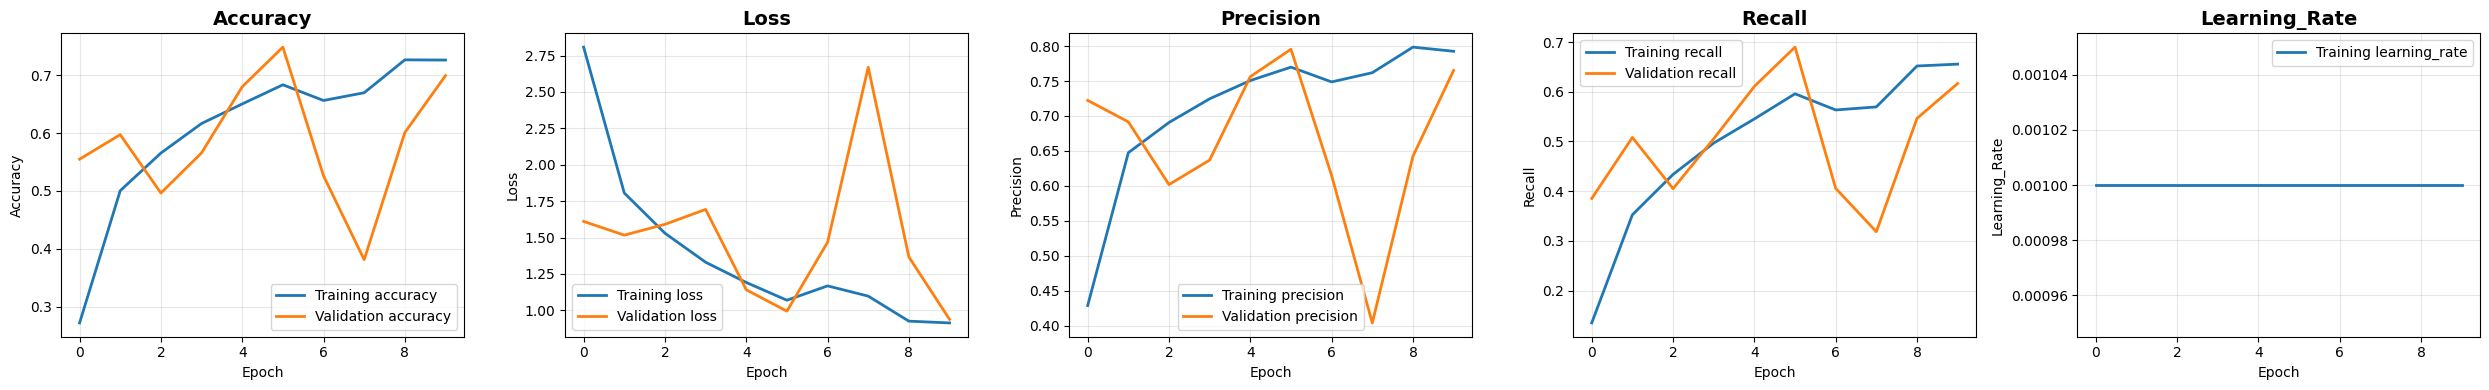

In [12]:
# Load best model if available, otherwise use current model
try:
    best_model = keras.models.load_model('best_plant_disease_model.h5')
    print("✅ Loaded best saved model!")
    model_to_evaluate = best_model
except:
    print("⚠️  No saved best model found, using final trained model")
    model_to_evaluate = model

# Evaluate model
print("=== COMPREHENSIVE MODEL EVALUATION ===")

# Evaluate on validation data
evaluation_metrics = model_to_evaluate.evaluate(validation_generator, verbose=1)

# Get metric names from the model
metric_names = [metric.name for metric in model_to_evaluate.metrics]
if 'loss' not in metric_names:
    metric_names = ['loss'] + metric_names

print("\n=== EVALUATION RESULTS ===")
for name, value in zip(metric_names, evaluation_metrics):
    print(f"{name.title()}: {value:.4f}")

# Calculate additional metrics if we have precision and recall
if len(evaluation_metrics) >= 4:  # Assuming loss, accuracy, precision, recall
    try:
        precision_idx = metric_names.index('precision')
        recall_idx = metric_names.index('recall')
        precision = evaluation_metrics[precision_idx]
        recall = evaluation_metrics[recall_idx]
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        print(f"F1-Score: {f1_score:.4f}")
    except:
        print("Could not calculate F1-score")

# Enhanced training history visualization
def plot_enhanced_training_history(history):
    # Check what metrics are available
    available_metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    val_metrics = [key for key in history.history.keys() if key.startswith('val_')]

    print(f"Available training metrics: {available_metrics}")
    print(f"Available validation metrics: {val_metrics}")

    # Create subplots based on available metrics
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("No training history available to plot")
        return

    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(available_metrics):
        axes[i].plot(history.history[metric], label=f'Training {metric}', linewidth=2)

        # Check if validation metric exists
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            axes[i].plot(history.history[val_metric], label=f'Validation {metric}', linewidth=2)

        axes[i].set_title(metric.title(), fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_enhanced_training_history(history)

Generating predictions...
234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step

=== PREDICTION STATISTICS ===
Total predictions: 7465
Unique predicted classes: 15
Unique true classes: 15

=== DETAILED CLASSIFICATION REPORT ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9407    0.6521    0.7702       365
                     Pepper__bell___healthy     0.9127    0.9110    0.9118       528
                      Potato___Early_blight     0.8061    0.9342    0.8655       365
                       Potato___Late_blight     0.6171    0.9096    0.7353       365
                           Potato___healthy     0.7407    0.3846    0.5063        52
                      Tomato_Bacterial_spot     0.9157    0.8177    0.8639       757
                        Tomato_Early_blight     0.6035    0.6630    0.6319       365
                         Tomato_Late_blight     0.8316    0.6952    0.7573       689
                 

<Figure size 1500x1200 with 0 Axes>

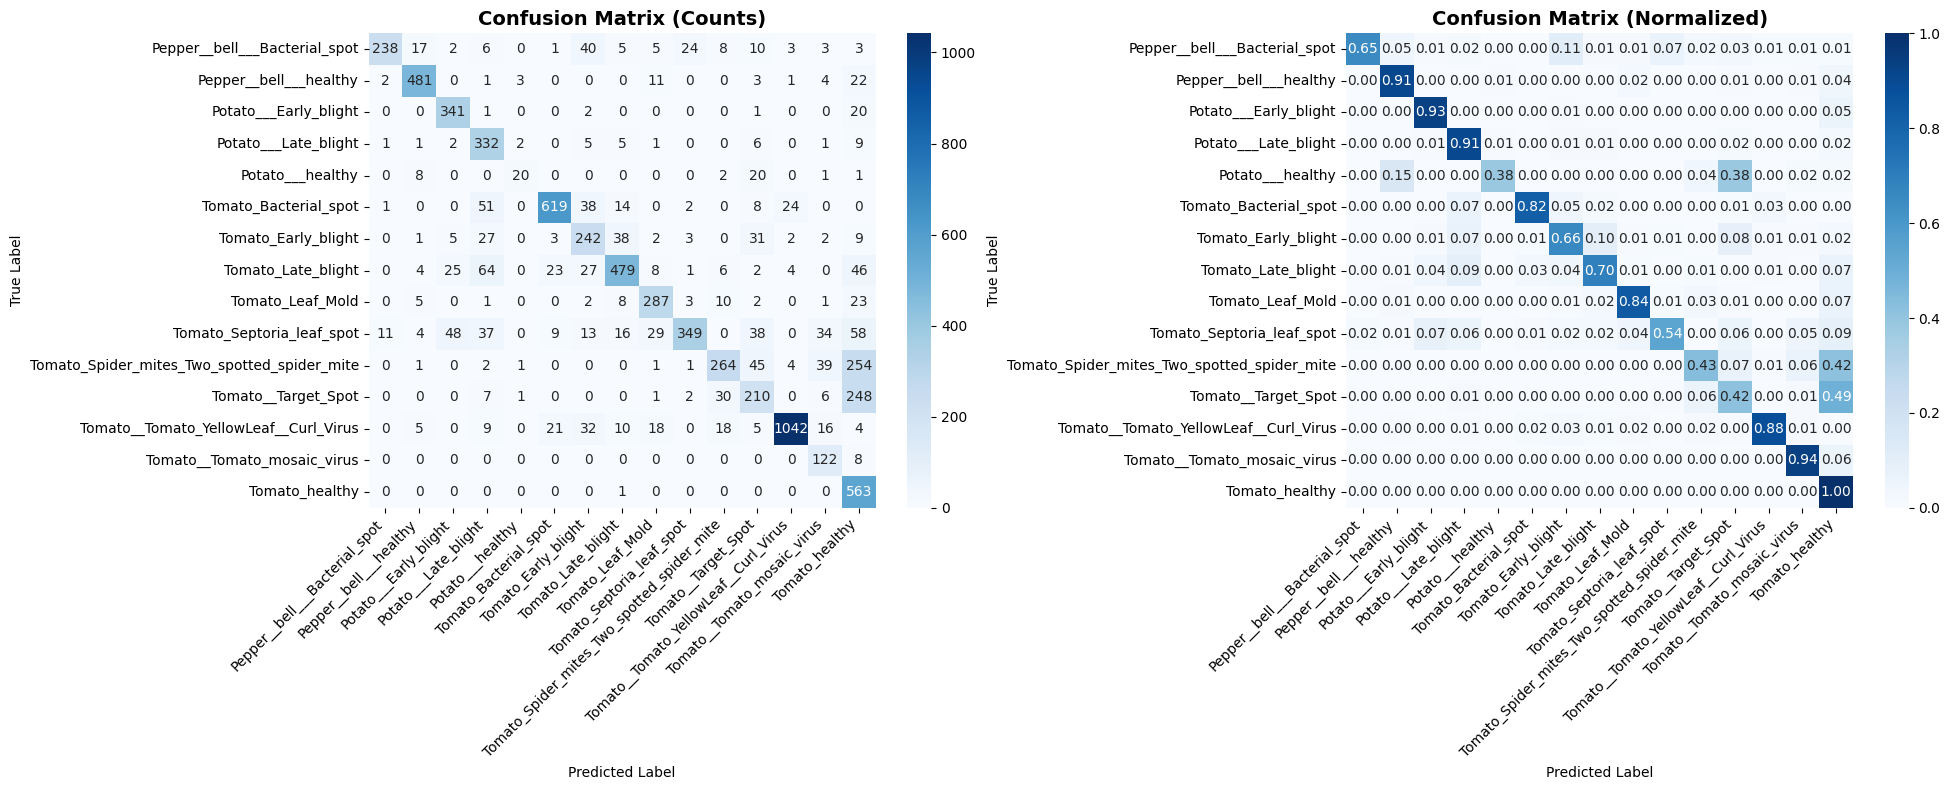

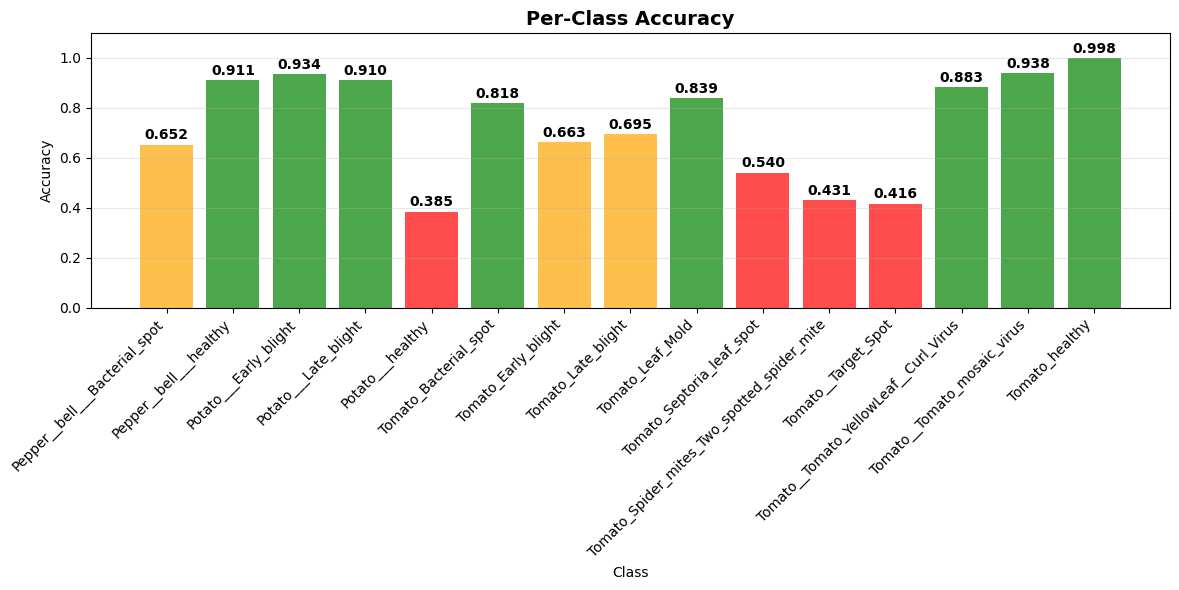


=== WORST PERFORMING CLASSES (Accuracy < 0.7) ===
  Potato___healthy: 0.385
  Tomato__Target_Spot: 0.416
  Tomato_Spider_mites_Two_spotted_spider_mite: 0.431
  Tomato_Septoria_leaf_spot: 0.540
  Pepper__bell___Bacterial_spot: 0.652
  Tomato_Early_blight: 0.663
  Tomato_Late_blight: 0.695


In [13]:
# Reset generator and get predictions
validation_generator.reset()
print("Generating predictions...")

y_pred = model_to_evaluate.predict(validation_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Get class names
class_names = list(validation_generator.class_indices.keys())

print(f"\n=== PREDICTION STATISTICS ===")
print(f"Total predictions: {len(y_pred)}")
print(f"Unique predicted classes: {len(np.unique(y_pred_classes))}")
print(f"Unique true classes: {len(np.unique(y_true))}")

# Enhanced classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Enhanced confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot regular confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# Plot normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            vmin=0, vmax=1)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Per-class accuracy analysis
per_class_accuracy = cm.diagonal() / (cm.sum(axis=1) + 1e-7)

plt.figure(figsize=(12, 6))
colors = ['green' if acc > 0.8 else 'orange' if acc > 0.6 else 'red' for acc in per_class_accuracy]
bars = plt.bar(range(len(class_names)), per_class_accuracy, color=colors, alpha=0.7)

plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, per_class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, min(1.2, max(per_class_accuracy) + 0.1))
plt.tight_layout()
plt.show()

# Display worst performing classes
print("\n=== WORST PERFORMING CLASSES (Accuracy < 0.7) ===")
low_accuracy_classes = []
for class_name, acc in zip(class_names, per_class_accuracy):
    if acc < 0.7:
        low_accuracy_classes.append((class_name, acc))

if low_accuracy_classes:
    for class_name, acc in sorted(low_accuracy_classes, key=lambda x: x[1]):
        print(f"  {class_name}: {acc:.3f}")
else:
    print("  All classes have accuracy >= 0.7! 🎉")

✅ Enhanced model saved successfully as 'final_enhanced_plant_disease_model.h5'

=== PREDICTION DEMO ===
To test the model with your own image:
1. Upload an image to Colab
2. Run: predicted_class, confidence, top_predictions = advanced_predict_plant_disease('your_image.jpg', model_to_evaluate, class_names)

🧪 Testing with sample image: plant_disease_dataset/PlantVillage/Tomato_Leaf_Mold/cf311eee-51fa-4c71-a012-8cb96db76f4c___Crnl_L.Mold 8700.JPG


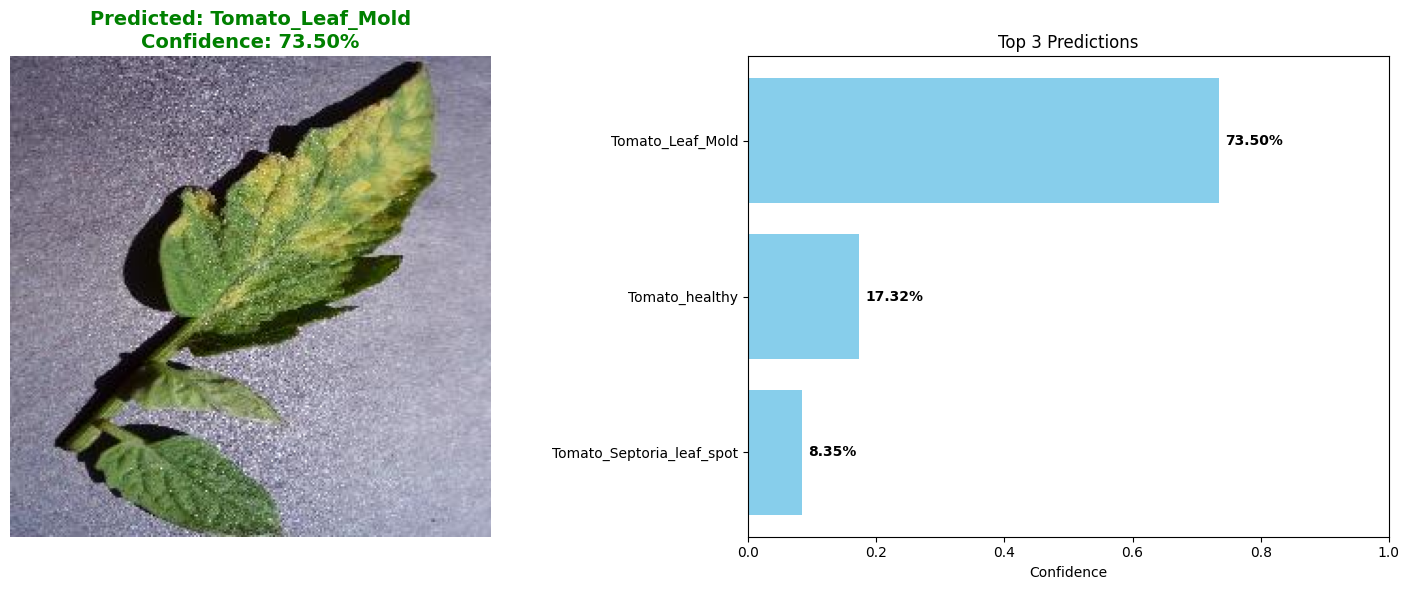

🎯 Final Prediction: Tomato_Leaf_Mold (Confidence: 73.50%)

📊 Top 3 Predictions:
   1. Tomato_Leaf_Mold: 73.50%
   2. Tomato_healthy: 17.32%
   3. Tomato_Septoria_leaf_spot: 8.35%


In [14]:
def advanced_predict_plant_disease(image_path, model, class_names, confidence_threshold=0.7):
    """Enhanced prediction with confidence thresholding"""
    try:
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        confidence = np.max(prediction)

        # Get top 3 predictions
        top_3_idx = np.argsort(prediction[0])[-3:][::-1]
        top_3_classes = [class_names[i] for i in top_3_idx]
        top_3_confidences = [prediction[0][i] for i in top_3_idx]

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Original image
        ax1.imshow(img)
        if confidence >= confidence_threshold:
            ax1.set_title(f'Predicted: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2%}',
                         fontsize=14, fontweight='bold', color='green')
        else:
            ax1.set_title(f'Low Confidence Prediction\nBest: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2%}',
                         fontsize=14, fontweight='bold', color='orange')
        ax1.axis('off')

        # Confidence bar chart
        y_pos = np.arange(len(top_3_classes))
        ax2.barh(y_pos, top_3_confidences, color='skyblue')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(top_3_classes)
        ax2.set_xlabel('Confidence')
        ax2.set_title('Top 3 Predictions')
        ax2.set_xlim(0, 1)
        ax2.invert_yaxis()

        # Add confidence values on bars
        for i, (class_name, conf) in enumerate(zip(top_3_classes, top_3_confidences)):
            ax2.text(conf + 0.01, i, f'{conf:.2%}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"🎯 Final Prediction: {class_names[predicted_class_idx]} (Confidence: {confidence:.2%})")
        print("\n📊 Top 3 Predictions:")
        for i, (cls, conf) in enumerate(zip(top_3_classes, top_3_confidences), 1):
            print(f"   {i}. {cls}: {conf:.2%}")

        return class_names[predicted_class_idx], confidence, list(zip(top_3_classes, top_3_confidences))

    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None, 0.0, []

# Save final model
model_to_evaluate.save('final_enhanced_plant_disease_model.h5')
print("✅ Enhanced model saved successfully as 'final_enhanced_plant_disease_model.h5'")

# Test the prediction function if we have sample images
print("\n=== PREDICTION DEMO ===")
print("To test the model with your own image:")
print("1. Upload an image to Colab")
print("2. Run: predicted_class, confidence, top_predictions = advanced_predict_plant_disease('your_image.jpg', model_to_evaluate, class_names)")

# Try to find a sample image for demo
sample_images = []
for root, dirs, files in os.walk('plant_disease_dataset'):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            sample_images.append(os.path.join(root, file))
            if len(sample_images) >= 1:  # Just get one sample
                break
    if sample_images:
        break

if sample_images:
    print(f"\n🧪 Testing with sample image: {sample_images[0]}")
    try:
        predicted_class, confidence, top_predictions = advanced_predict_plant_disease(
            sample_images[0], model_to_evaluate, class_names
        )
    except Exception as e:
        print(f"Sample prediction failed: {e}")
else:
    print("No sample images found for demo")

In [15]:
print("=== MODEL TRAINING SUMMARY ===")
print(f"✅ Model Architecture: Enhanced CNN with {num_classes} classes")
print(f"✅ Training Samples: {train_generator.samples}")
print(f"✅ Validation Samples: {validation_generator.samples}")
print(f"✅ Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"✅ Classes: {', '.join(class_names)}")

# Display final metrics
final_accuracy = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else history.history['accuracy'][-1]
print(f"✅ Final Validation Accuracy: {final_accuracy:.4f}")

print("\n=== NEXT STEPS ===")
print("1. The model is saved as 'final_enhanced_plant_disease_model.h5'")
print("2. You can load it later using: model = tf.keras.models.load_model('final_enhanced_plant_disease_model.h5')")
print("3. To improve further, consider:")
print("   - Training for more epochs")
print("   - Using transfer learning (ResNet, EfficientNet)")
print("   - Hyperparameter tuning")
print("   - Gathering more diverse training data")

print("\n🎉 Plant Disease Classification Pipeline Complete! 🎉")

=== MODEL TRAINING SUMMARY ===
✅ Model Architecture: Enhanced CNN with 15 classes
✅ Training Samples: 19842
✅ Validation Samples: 7465
✅ Image Size: 256x256
✅ Classes: Pepper__bell___Bacterial_spot, Pepper__bell___healthy, Potato___Early_blight, Potato___Late_blight, Potato___healthy, Tomato_Bacterial_spot, Tomato_Early_blight, Tomato_Late_blight, Tomato_Leaf_Mold, Tomato_Septoria_leaf_spot, Tomato_Spider_mites_Two_spotted_spider_mite, Tomato__Target_Spot, Tomato__Tomato_YellowLeaf__Curl_Virus, Tomato__Tomato_mosaic_virus, Tomato_healthy
✅ Final Validation Accuracy: 0.6994

=== NEXT STEPS ===
1. The model is saved as 'final_enhanced_plant_disease_model.h5'
2. You can load it later using: model = tf.keras.models.load_model('final_enhanced_plant_disease_model.h5')
3. To improve further, consider:
   - Training for more epochs
   - Using transfer learning (ResNet, EfficientNet)
   - Hyperparameter tuning
   - Gathering more diverse training data

🎉 Plant Disease Classification Pipeline Co